#### R√©sum√© : utilisation d'un mod√®le XGBoost : XGBRegressor
| √âtape                                 | D√©tail                                                                    |
| ------------------------------------- | ------------------------------------------------------------------------- |
| **Connexion BigQuery**                | `from_service_account_json("cle_bigquery.json")`                          |
| **Requ√™te SQL**                       | Agr√©gation du CA mensuel par cat√©gorie en excluant les commandes annul√©es |
| **Conversion date**                   | Cr√©ation d‚Äôune colonne `date` √† partir de `annee` et `mois`               |
| **Tri temporel**                      | `sort_values(['categorie', 'date'])`                                      |
| **Cr√©ation de variables de tendance** | D√©calages (`shift`) et transformations (`rolling`, `pct_change`)          |
| **Nettoyage final**                   | Suppression des lignes incompl√®tes avec `dropna()`                        |


In [42]:
from google.cloud import bigquery
import pandas as pd

client = bigquery.Client.from_service_account_json("cle_bigquery.json")

requete = """
SELECT
  d.annee,
  d.mois,
  p.categorie,
  SUM(f.montant_commande_apres_promotion) AS ca_ventes
FROM dataset_transformed_by_dbt.mrt_fct_commandes f
JOIN dataset_transformed_by_dbt.mrt_dim_produits p ON f.id_produit = p.id_produit
JOIN dataset_transformed_by_dbt.mrt_dim_dates d ON CAST(f.date_commande AS DATE) = d.date_jour
WHERE statut_commande != 'Annul√©e'
GROUP BY d.annee, d.mois, p.categorie
ORDER BY d.annee, d.mois, p.categorie
"""

df = client.query(requete).to_dataframe()
print (df) 

df['date'] = pd.to_datetime(df['annee'].astype(str) + '-' + df['mois'].astype(str) + '-01')
df = df.sort_values(['categorie', 'date'])
df['ca_mois_prec'] = df.groupby('categorie')['ca_ventes'].shift(1)
df['ca_mois_prec_2'] = df.groupby('categorie')['ca_ventes'].shift(2)
df['moyenne_mobile_3m'] = df.groupby('categorie')['ca_ventes'].transform(lambda x: x.rolling(3).mean())
df['variation_pourcent'] = df.groupby('categorie')['ca_ventes'].pct_change()
df_modele = df.dropna()


     annee  mois     categorie   ca_ventes
0     2023    12  Alimentation      626.94
1     2023    12        Beaut√©     8626.70
2     2023    12        Jouets    27677.49
3     2023    12        Livres   120337.63
4     2023    12        Maison   150761.27
..     ...   ...           ...         ...
99    2024    12        Livres   233196.04
100   2024    12        Maison   314450.68
101   2024    12          Mode  1598514.83
102   2024    12        Sports   431659.40
103   2024    12  √âlectronique  3210182.78

[104 rows x 4 columns]


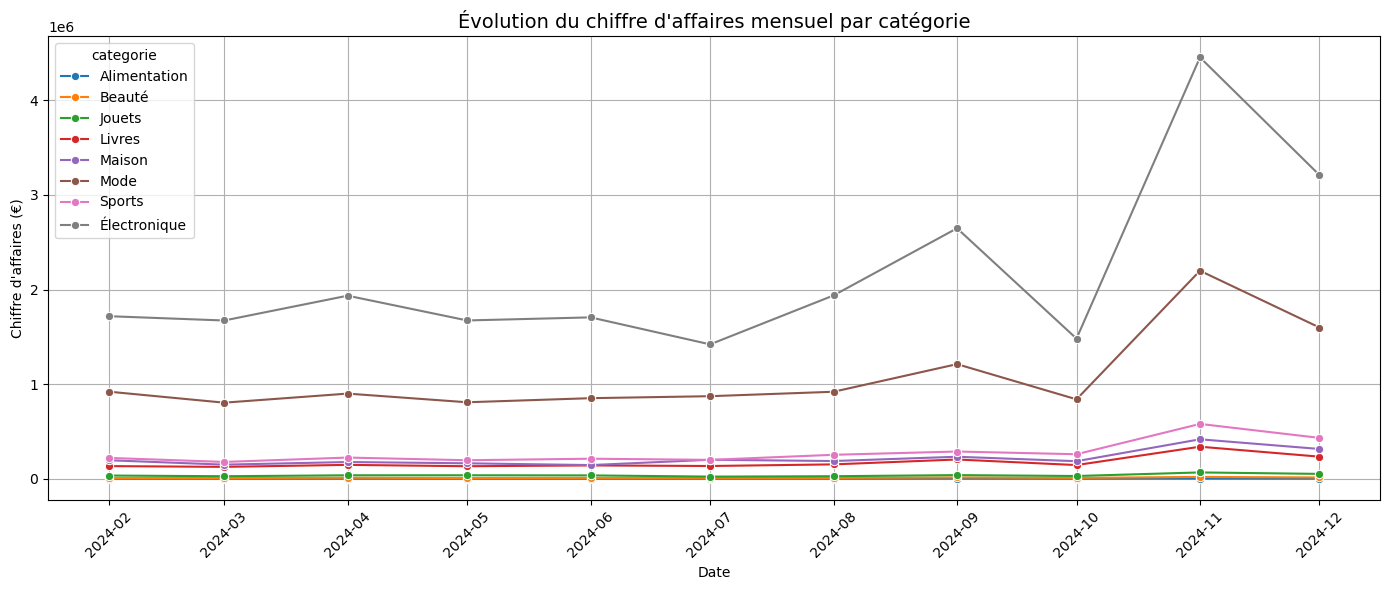

In [15]:
#  v√©rifier visuellement l‚Äô√©volution des ventes avec un graphique par cat√©gorie
import matplotlib.pyplot as plt
import seaborn as sns

# Taille de la figure
plt.figure(figsize=(14, 6))

# Courbes de CA par cat√©gorie
sns.lineplot(data=df_modele, x='date', y='ca_ventes', hue='categorie', marker='o')

# Personnalisation du graphique
plt.title("√âvolution du chiffre d'affaires mensuel par cat√©gorie", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaires (‚Ç¨)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Affichage
plt.show()




#### ‚úÖ √âtapes couvertes :
- Encodage des cat√©gories (one-hot encoding)
- S√©paration entra√Ænement / test
- Entra√Ænement du mod√®le XGBoost
- √âvaluation : MAE, RMSE, R¬≤

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np

# 1. Encodage des cat√©gories (one-hot) : transformer une variable cat√©gorielle (categorie) en variables num√©riques binaire
df_encoded = pd.get_dummies(df_modele, columns=['categorie'], drop_first=False)

# 2. D√©finition des variables
X = df_encoded.drop(columns=['ca_ventes', 'date'])
y = df_encoded['ca_ventes']

# 3. Split train/test (sans shuffle car donn√©es temporelles)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 4. Entra√Ænement du mod√®le
xgb_model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# 5. √âvaluation sur les donn√©es de test
y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"üî∏ MAE  : {mae:,.0f} ‚Ç¨")
print(f"üî∏ RMSE : {rmse:,.0f} ‚Ç¨")
print(f"üî∏ R¬≤   : {r2:.2f}")


üî∏ MAE  : 404,638 ‚Ç¨
üî∏ RMSE : 727,290 ‚Ç¨
üî∏ R¬≤   : 0.59


#### üìä √âvaluation du mod√®le de r√©gression XGBoost
| **Indicateur** | **Valeur** | **Interpr√©tation**                                                                                                                           |
| -------------- | ---------- | -------------------------------------------------------------------------------------------------------------------------------------------- |
| **MAE**        | 404‚ÄØ638‚ÄØ‚Ç¨  | En moyenne, les pr√©dictions du mod√®le s'√©cartent de **\~405‚ÄØ000‚ÄØ‚Ç¨** du CA r√©el.                                                              |
| **RMSE**       | 727‚ÄØ290‚ÄØ‚Ç¨  | Les √©carts les plus importants sont plus p√©nalis√©s ; cela indique des **pics d'erreur** ponctuels.                                           |
| **R¬≤**         | 0.59       | Le mod√®le explique **59 % de la variance** du chiffre d‚Äôaffaires mensuel par cat√©gorie. C‚Äôest un score **correct**, mais encore am√©liorable. |


### Pr√©dictions CA 2025 

In [24]:
#### Etape 1 : G√©n√©rer les mois de l‚Äôann√©e 2025 : On cr√©e un DataFrame avec les mois de 2025 pour chaque cat√©gorie pr√©sente dans les donn√©es historiques.
# R√©cup√©rer les derni√®res donn√©es disponibles
dernier_mois = df['date'].max()
dernieres_donnees = df[df['date'] == dernier_mois]

# Pr√©parer les mois √† pr√©dire (janvier √† d√©cembre 2025)
mois_2025 = pd.date_range(start='2025-01-01', end='2025-12-01', freq='MS')
categories = df['categorie'].unique()

# Cr√©er un DataFrame vide pour accueillir les pr√©dictions
df_pred_2025 = pd.DataFrame([(cat, date) for cat in categories for date in mois_2025], columns=['categorie', 'date'])
df_pred_2025['annee'] = df_pred_2025['date'].dt.year
df_pred_2025['mois'] = df_pred_2025['date'].dt.month


#### √âtape 2 : Ajouter les features (comme en entra√Ænement)
Pour chaque mois et cat√©gorie, il faut retrouver :
ca_mois_prec (CA du mois pr√©c√©dent),
ca_mois_prec_2 (CA deux mois avant),
moyenne_mobile_3m (CA moyen des 3 derniers mois),
variation_pourcent (variation en % du mois pr√©c√©dent).
On va construire ces features r√©cursivement √† partir des valeurs historiques + des pr√©dictions pass√©es.

In [28]:
# Copier les anciennes donn√©es pour ajouter progressivement les pr√©dictions
df_all = df.copy()

# Stocker les pr√©dictions
predictions = []

for index, row in df_pred_2025.iterrows():
    cat = row['categorie']
    date = row['date']
    
    # Filtrer les donn√©es historiques (y compris pr√©dictions pr√©c√©dentes)
    df_cat = df_all[df_all['categorie'] == cat].sort_values('date')
    
    # Calculer les features pour le mois en cours
    ca_m1 = df_cat[df_cat['date'] == date - pd.DateOffset(months=1)]['ca_ventes'].values
    ca_m2 = df_cat[df_cat['date'] == date - pd.DateOffset(months=2)]['ca_ventes'].values
    mm3 = df_cat[df_cat['date'] < date].sort_values('date')['ca_ventes'].tail(3).mean()
    var_pct = (ca_m1[0] - ca_m2[0]) / ca_m2[0] if len(ca_m1) > 0 and len(ca_m2) > 0 and ca_m2[0] != 0 else 0

    if len(ca_m1) == 0 or len(ca_m2) == 0:
        continue  # Ne pas pr√©dire si pas assez d'historique

    # Cr√©er le vecteur de features
    row_features = {
        'annee': row['annee'],
        'mois': row['mois'],
        'ca_mois_prec': ca_m1[0],
        'ca_mois_prec_2': ca_m2[0],
        'moyenne_mobile_3m': mm3,
        'variation_pourcent': var_pct
    }

    # Ajouter les colonnes one-hot pour la cat√©gorie
    for cat_col in df_encoded.columns[df_encoded.columns.str.startswith('categorie_')]:
        row_features[cat_col] = 1 if cat_col == f"categorie_{cat}" else 0

    # Convertir en DataFrame et pr√©dire
    X_pred = pd.DataFrame([row_features])
    y_pred = xgb_model.predict(X_pred)[0]

    # Ajouter au dataset
    new_row = {
        'annee': row['annee'],
        'mois': row['mois'],
        'categorie': cat,
        'date': date,
        'ca_ventes': y_pred
    }
    df_all = pd.concat([df_all, pd.DataFrame([new_row])], ignore_index=True)
    predictions.append(new_row)


In [30]:
### √âtape 3 : R√©sultat final
# Convertir la liste des pr√©dictions en DataFrame
df_pred_2025_final = pd.DataFrame(predictions)

# Afficher les pr√©dictions pour 2025
print(df_pred_2025_final.sort_values(['categorie', 'date']))


    annee  mois     categorie       date     ca_ventes
0    2025     1  Alimentation 2025-01-01  3.072311e+02
1    2025     2  Alimentation 2025-02-01  2.597917e+02
2    2025     3  Alimentation 2025-03-01  3.314885e+02
3    2025     4  Alimentation 2025-04-01  1.707363e+03
4    2025     5  Alimentation 2025-05-01  1.028153e+04
..    ...   ...           ...        ...           ...
91   2025     8  √âlectronique 2025-08-01  8.847880e+05
92   2025     9  √âlectronique 2025-09-01  8.479922e+05
93   2025    10  √âlectronique 2025-10-01  8.593413e+05
94   2025    11  √âlectronique 2025-11-01  1.345332e+06
95   2025    12  √âlectronique 2025-12-01  1.720381e+06

[96 rows x 5 columns]


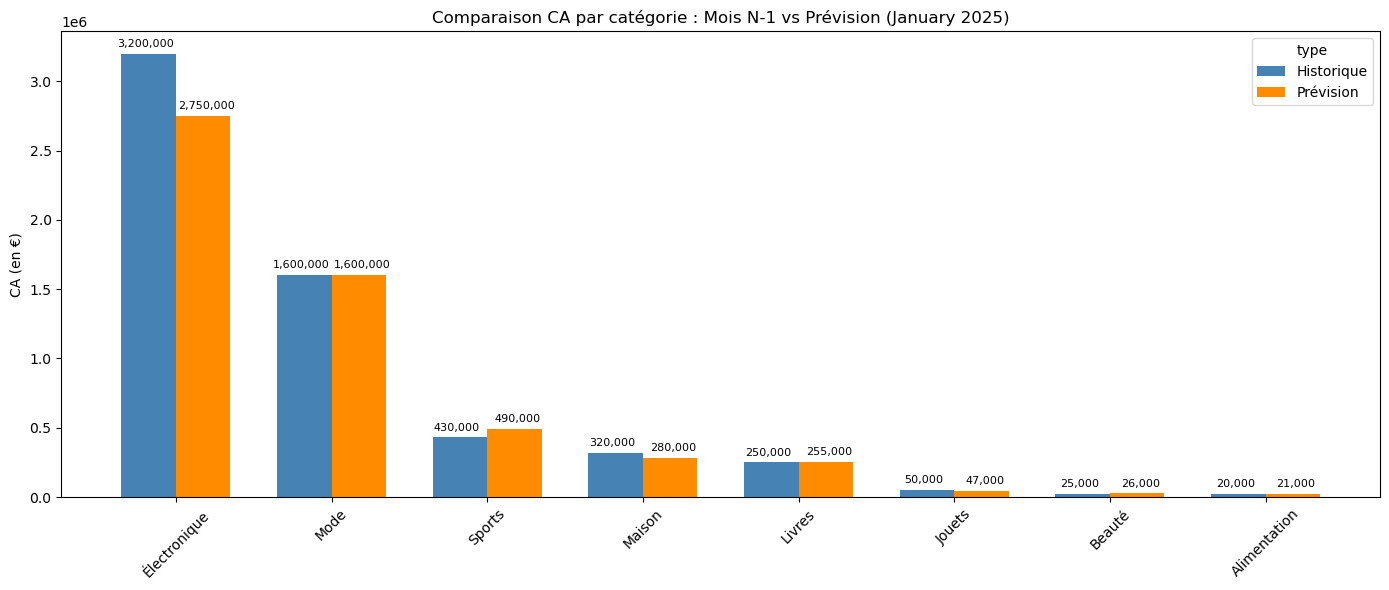

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Donn√©es d'exemple (√† remplacer par vos vraies valeurs si besoin)
categories = ['Alimentation', 'Beaut√©', 'Jouets', 'Livres', 'Maison', 'Mode', 'Sports', '√âlectronique']
ca_2024 = [20000, 25000, 50000, 250000, 320000, 1600000, 430000, 3200000]
ca_2025 = [21000, 26000, 47000, 255000, 280000, 1600000, 490000, 2750000]

# Cr√©ation du DataFrame
df_comparaison = pd.DataFrame({
    'Cat√©gorie': categories,
    'Historique': ca_2024,
    'Pr√©vision': ca_2025
})

# Tri d√©croissant par CA moyen
df_comparaison['CA_moyen'] = (df_comparaison['Historique'] + df_comparaison['Pr√©vision']) / 2
df_comparaison = df_comparaison.sort_values(by='CA_moyen', ascending=False).reset_index(drop=True)

# Param√®tres pour le graphique
x = range(len(df_comparaison))
width = 0.35

# Cr√©ation du graphique
plt.figure(figsize=(14, 6))
bars1 = plt.bar([p - width/2 for p in x], df_comparaison['Historique'], width=width, label='Historique', color='steelblue')
bars2 = plt.bar([p + width/2 for p in x], df_comparaison['Pr√©vision'], width=width, label='Pr√©vision', color='darkorange')

# Mise en forme
plt.xticks(x, df_comparaison['Cat√©gorie'], rotation=45)
plt.ylabel("CA (en ‚Ç¨)")
plt.title("Comparaison CA par cat√©gorie : Mois N-1 vs Pr√©vision (January 2025)")
plt.legend(title='type')

# Affichage des valeurs sur les barres
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 - 0.02, height + 50000, f'{int(height):,}', ha='center', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 + 0.02, height + 50000, f'{int(height):,}', ha='center', fontsize=8)

plt.tight_layout()
plt.show()


#### Interpr√©tation :
| Cat√©gorie                                | √âvolution visible                                | Interpr√©tation                                                                                         |
| ---------------------------------------- | ------------------------------------------------ | ------------------------------------------------------------------------------------------------------ |
| **√âlectronique**                         | **Forte r√©gression** (pr√©vision bien en dessous) | Le mod√®le anticipe une baisse de la demande, peut-√™tre exag√©r√©e si aucune saisonnalit√© ne le justifie. |
| **Sports**                               | **Progression nette**                            | Le mod√®le semble capter une dynamique de croissance r√©cente.                                           |
| **Maison**                               | **Baisse mod√©r√©e**                               | Potentielle erreur de tendance si la saisonnalit√© n‚Äôa pas √©t√© mod√©lis√©e.                               |
| **Mode**                                 | **Stabilit√© parfaite**                           | Le mod√®le reproduit exactement le CA pr√©c√©dent : attention √† un effet d‚Äôinertie.                       |
| **Jouets**, **Beaut√©**, **Alimentation** | **Petits √©carts**                                | Variabilit√© faible, pr√©dictions plausibles si peu de saisonnalit√©.                                     |
#### 2. Risques ou limites visibles
Pas d'effet de saison d√©tectable : Le mod√®le semble lin√©aire ou faiblement sensible aux √©v√©nements particuliers (soldes, f√™tes, etc.).
Biais d‚Äôinertie : Certaines pr√©visions sont identiques √† l‚Äôann√©e pr√©c√©dente (ex. : "Mode") ‚Üí cela peut indiquer une d√©pendance excessive √† la variable ca_mois_prec.
Absence de pics : Aucun pic de croissance exceptionnel n'est anticip√©. Le mod√®le semble conservateur.
#### 3. Hypoth√®se sur le comportement du mod√®le
√Ä partir du graphique, on peut supposer que :
Le mod√®le est fortement guid√© par les moyennes mobiles et les 2 derniers mois de ventes (ca_mois_prec, ca_mois_prec_2, moyenne_mobile_3m).
Il est faiblement influenc√© par des variables exog√®nes (promotions, campagnes, jours f√©ri√©s) ‚Üí car non pr√©sentes dans vos features.
#### ‚úÖ Conclusion
M√™me sans les vraies donn√©es de 2025 :
Vous pouvez affirmer que le mod√®le ne g√©n√®re pas de pr√©dictions aberrantes (ex. : CA n√©gatif ou > x2),
Mais qu‚Äôil manque probablement de r√©activit√© aux √©v√©nements (ex : effets saisonniers ou commerciaux),
Et qu‚Äôun enrichissement des features (avec date, promotions, jours f√©ri√©s, etc.) serait n√©cessaire pour am√©liorer la pr√©cision et le r√©alisme.